In [1]:
# Load Packages

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import os
import numpy as np
import networkx as nx
import itertools
import copy
import datetime, time


from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from numpy import array 

In [2]:
#Import Dataset

filename = '/Users/Geoff/Desktop/MMAI/CAPSTONE/aragon-all-votes_outcome feature.csv'
df = pd.read_csv(filename)

In [3]:
#Prepare data

df['vote'] = df['vote'].eq('Yes').astype(int)
df['Result'] = df['Result'].eq('Yes').astype(int)
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
df['timestamp'] = df['timestamp'].values.astype(np.float)

In [4]:
#Normalise data across votes

#group by vote 
df_vote  = df.groupby('voting_number')
print(type(df_vote))

#normalise timestamps and stake amount across groups
df['timestamp_norm'] = df.groupby('voting_number')['timestamp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
df['staked_norm'] = df.groupby('voting_number')['staked_ANT_amount'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

<class 'pandas.core.groupby.groupby.DataFrameGroupBy'>


# Vote 9

In [5]:
#Get Data From Vote 1 for calulation
df = df[(df['voting_number']==8)]

In [6]:
votes = df[['timestamp_norm','staked_norm']]

In [7]:
votes 

,timestamp_norm,staked_norm
273,0.000000,0.000017
274,0.002982,0.042541
275,0.010819,0.030196
276,0.015628,0.000126
277,0.016806,0.000938
278,0.032075,0.081030
279,0.041167,0.000078
280,0.043743,0.000144
281,0.044851,0.000698
282,0.052647,0.000598


In [8]:
#Calculate the Gini-Coefficient of votes (Adapted from: https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation)

time = votes['timestamp_norm'].values
staked = votes['staked_norm'].values

In [9]:
#Definie Gini Function

def gini(staked, time):
    assert (len(staked) == len(time))
    all = np.asarray(np.c_[staked, time, np.arange(len(time))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(staked) + 1) / 2.
    return giniSum / len(staked)


def gini_normalized(staked, time):
    return gini(staked, time) / gini(staked, time)

gini_time = gini(staked, time)
gini_max = gini(staked, time)
ngini= gini_normalized(staked, time)
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_time, gini_max, ngini))

Gini: 0.232, Max. Gini: 0.232, Normalized Gini: 1.000


In [10]:
# Sort the actual values by the staked
data = zip(staked, time)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]
print('Sorted Actual Values', sorted_actual)

Sorted Actual Values [1.722610100845169e-05, 0.04254142251442935, 0.03019617689540134, 0.0001261644830947384, 0.0009384232875605034, 0.08103014387643236, 7.780683636075223e-05, 0.0001439334580680787, 0.0006978315722986076, 0.00059836179362726, 0.0004417449642253488, 6.243900265106448e-06, 0.0019069997103590695, 0.10437515962667089, 0.22124053117029013, 0.0072738629489868525, 1.8867119510330862e-05, 0.006311541913254702, 0.0366072681017933, 0.0004276279291199008, 0.00025075565704510335, 0.0, 0.014126079782483163, 0.0025245761396873773, 0.00661841703233633, 0.03187353563839565, 0.00028559614294913375, 2.2275388706541454e-05, 0.0025245635164681322, 0.039510608528194914, 0.00028150572596711204, 0.00027563368751304124, 1.1946125670166827e-06, 0.020892791589304877, 0.0005048610604514709, 1.8867119510330862e-05, 1.0, 0.0013831846555341857]


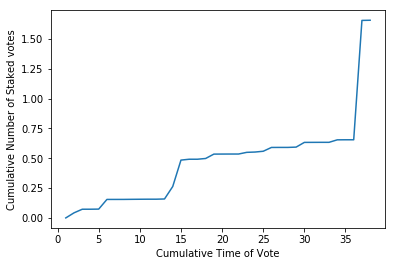

In [11]:
# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

plt.plot(cumulative_index, cumulative_actual)
plt.xlabel('Cumulative Time of Vote')
plt.ylabel('Cumulative Number of Staked votes')
plt.show()

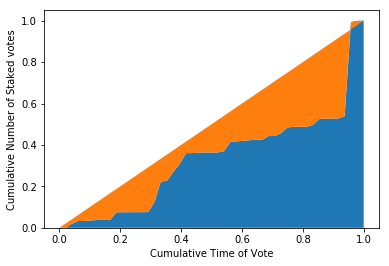

In [12]:
cumulative_actual_votes = cumulative_actual / sum(staked)
cumulative_index_time = cumulative_index / len(time)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_time)
y_values = [0] + list(cumulative_actual_votes)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Time of Vote')
plt.ylabel('Cumulative Number of Staked votes')
plt.show()